# Data Visualization for US Accident Analysis

##### Revna Altınöz , 150220756
##### Eda Selin Küçükkara , 150210325



## In this project, we will do visualization for:

##### •	Line charts for yearly, monthly, and daily accident trends. 

##### •	Heatmaps for hourly vs. day-of-the-week accident frequency. 

##### •	Bar plots and pivot tables to show the number of accidents per state. 

##### •	Boxplots to visualize how severity varies under different weather conditions.

##### •	Seasonal decomposition charts to highlight recurring patterns.

##### •	Geospatial heatmaps to identify accident hotspots across states and cities.

##### •	Bubble maps highlighting the most dangerous cities.

##### •	Interactive Dashboard



## Requirements:

In [26]:
!pip install kaggle
!pip install basemap basemap-data-hires
!pip install dash dash-bootstrap-components plotly
!pip install basemap


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [27]:
!kaggle datasets download -d sobhanmoosavi/us-accidents

Dataset URL: https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents
License(s): CC-BY-NC-SA-4.0
us-accidents.zip: Skipping, found more recently modified local copy (use --force to force download)


In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib
from mpl_toolkits.basemap import Basemap
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px
import dash_bootstrap_components as dbc
import zipfile 

In [29]:
# Path to the downloaded zip file 
zip_file_path = 'us-accidents.zip' 
# Unzip the file 
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref: 
    zip_ref.extractall()

In [30]:
# Load the dataset
df = pd.read_csv('US_Accidents_March23.csv')
print(df.head())
df.info()

    ID   Source  Severity           Start_Time             End_Time   
0  A-1  Source2         3  2016-02-08 05:46:00  2016-02-08 11:00:00  \
1  A-2  Source2         2  2016-02-08 06:07:59  2016-02-08 06:37:59   
2  A-3  Source2         2  2016-02-08 06:49:27  2016-02-08 07:19:27   
3  A-4  Source2         3  2016-02-08 07:23:34  2016-02-08 07:53:34   
4  A-5  Source2         2  2016-02-08 07:39:07  2016-02-08 08:09:07   

   Start_Lat  Start_Lng  End_Lat  End_Lng  Distance(mi)  ... Roundabout   
0  39.865147 -84.058723      NaN      NaN          0.01  ...      False  \
1  39.928059 -82.831184      NaN      NaN          0.01  ...      False   
2  39.063148 -84.032608      NaN      NaN          0.01  ...      False   
3  39.747753 -84.205582      NaN      NaN          0.01  ...      False   
4  39.627781 -84.188354      NaN      NaN          0.01  ...      False   

  Station   Stop Traffic_Calming Traffic_Signal Turning_Loop Sunrise_Sunset   
0   False  False           False          F

## Preprocessing

##### We filtered the dataset to include only the relevant columns necessary for our analysis and visualizations. We addressed timestamp formatting issues by standardizing the Start_Time column and converting it into a proper datetime format. Additionally, we extracted date features, such as year, month, and day, to enable time-based analysis.

In [31]:
# We will be only using these columns, so we select them
columns_to_use = [
    'ID', 'Severity', 'Start_Time', 'End_Time', 
    'Start_Lat', 'Start_Lng', 'Street', 
    'City', 'County', 'State', 'Wind_Speed(mph)', 'Weather_Condition'
]

filtered_data = df[columns_to_use]

# Display the first few rows
print(filtered_data.head())

# We handle timestamp conversion issues
problematic_rows = df.loc[~df['Start_Time'].str.match(r'^\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}$', na=False)]
print(problematic_rows['Start_Time'].head())
df['Start_Time'] = df['Start_Time'].str.split('.').str[0]
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
print(df['Start_Time'].isna().sum())
print(df['Start_Time'].head())
print(df['Start_Time'].dtype)

# Extract date related features
df['Year'] = df['Start_Time'].dt.year
df['Month'] = df['Start_Time'].dt.month
df['Day'] = df['Start_Time'].dt.date
print(df[['Start_Time', 'Year', 'Month', 'Day']].head())


    ID  Severity           Start_Time             End_Time  Start_Lat   
0  A-1         3  2016-02-08 05:46:00  2016-02-08 11:00:00  39.865147  \
1  A-2         2  2016-02-08 06:07:59  2016-02-08 06:37:59  39.928059   
2  A-3         2  2016-02-08 06:49:27  2016-02-08 07:19:27  39.063148   
3  A-4         3  2016-02-08 07:23:34  2016-02-08 07:53:34  39.747753   
4  A-5         2  2016-02-08 07:39:07  2016-02-08 08:09:07  39.627781   

   Start_Lng                     Street          City      County State   
0 -84.058723                     I-70 E        Dayton  Montgomery    OH  \
1 -82.831184                   Brice Rd  Reynoldsburg    Franklin    OH   
2 -84.032608             State Route 32  Williamsburg    Clermont    OH   
3 -84.205582                     I-75 S        Dayton  Montgomery    OH   
4 -84.188354  Miamisburg Centerville Rd        Dayton  Montgomery    OH   

   Wind_Speed(mph) Weather_Condition  
0              NaN        Light Rain  
1              NaN        Light 

## Line charts for yearly, monthly, and daily accident trends

##### These visualizations analyze accident trends over time. The yearly and monthly trends combine bar charts with line plots to provide a clear comparison of yearly and seasonal accident variations. The yearly plot has long-term patterns, while the monthly chart highlights seasonal fluctuations across months. The daily trend uses a line plot to capture day-to-day variations, showing short-term patterns and anomalies over time. 

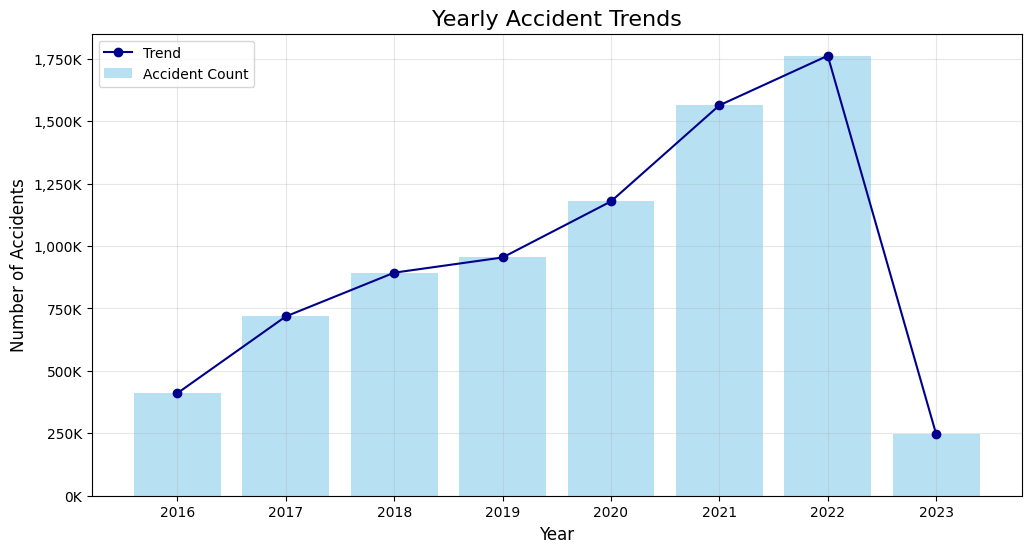

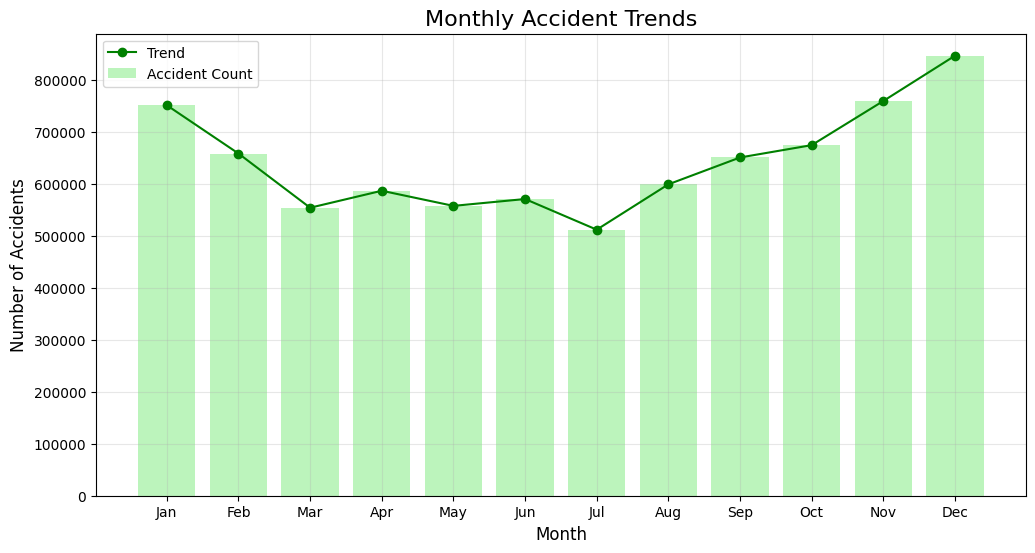

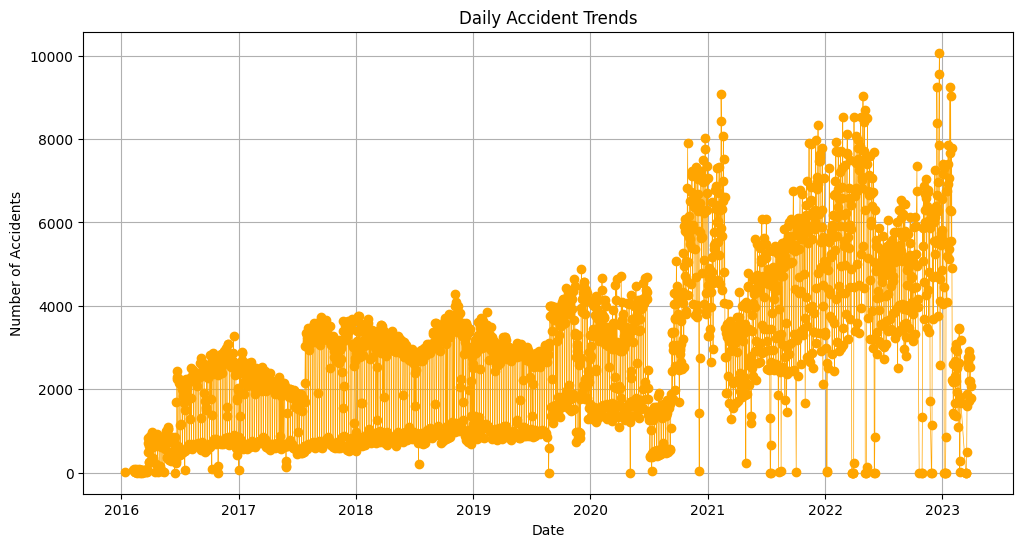

In [32]:
# Accidents per year, month, and day
yearly_accidents = df.groupby('Year').size()
monthly_accidents = df.groupby('Month').size()
daily_accidents = df.groupby('Day').size()

# Line chart inside a bar chart for yearly trends
plt.figure(figsize=(12, 6))
plt.bar(yearly_accidents.index, yearly_accidents.values, alpha=0.6, color='skyblue', label='Accident Count')
plt.plot(yearly_accidents.index, yearly_accidents.values, marker='o', color='darkblue', label='Trend')
plt.title('Yearly Accident Trends', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Accidents', fontsize=12)
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}K".format(int(x / 1000))))
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Line chart inside a bar chart for monthly trends
plt.figure(figsize=(12, 6))
plt.bar(monthly_accidents.index, monthly_accidents.values, alpha=0.6, color='lightgreen', label='Accident Count')
plt.plot(monthly_accidents.index, monthly_accidents.values, marker='o', color='green', label='Trend')
plt.title('Monthly Accident Trends', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Accidents', fontsize=12)
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# Plot for daily trends
plt.figure(figsize=(12, 6))
daily_accidents.plot(kind='line', marker='o', linestyle='-', linewidth=0.5, color='orange')
plt.title('Daily Accident Trends')
plt.xlabel('Date')
plt.ylabel('Number of Accidents')
plt.grid()
plt.show()


## Heatmaps for hourly vs. day-of-the-week accident frequency

##### This heatmap visualizes the percentage distribution of accidents across hours of the day and days of the week. Each cell represents the proportion of accidents occurring at a specific hour on a particular day, normalized as a percentage of the total accidents for that day. The color intensity highlights periods with higher accident frequencies, providing insights into peak times, such as rush hours or weekends. 

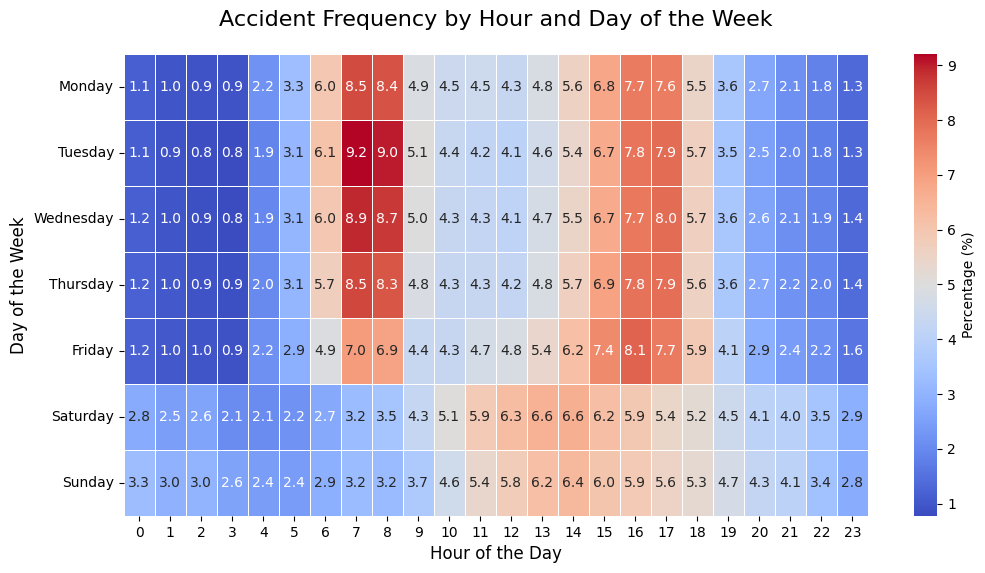

In [33]:
df['Hour'] = df['Start_Time'].dt.hour
df['Day_of_Week'] = df['Start_Time'].dt.dayofweek
day_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df['Day_of_Week'] = df['Day_of_Week'].map(day_map)

heatmap_data = df.pivot_table(index='Day_of_Week', columns='Hour', aggfunc='size', fill_value=0)
heatmap_data = heatmap_data.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Normalize the data to show percentages
heatmap_data_percentage = heatmap_data.div(heatmap_data.sum(axis=1), axis=0) * 100

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data_percentage, cmap='coolwarm', annot=True, fmt='.1f', cbar_kws={'label': 'Percentage (%)'}, linewidths=.5)
plt.title('Accident Frequency by Hour and Day of the Week', fontsize=16, pad=20)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Day of the Week', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10, rotation=0)
plt.show()


## Bar plots and pivot tables to show the number of accidents per state

##### These bar plots visualize the top 10 states with the highest number of accidents and the least 10 states with the fewest accidents. The top plot highlights states like California as having the highest accident counts, contributing to the total accidents, while the bottom plot shows states like South Dakota and Vermont with the lowest accident counts. The annotations include the exact number of accidents and their respective percentages, providing a comparison of accident distribution across states. 

/var/folders/l_/p30b7fvj58l9wzkln6ww9qg00000gn/T/ipykernel_41950/2388955990.py:10: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



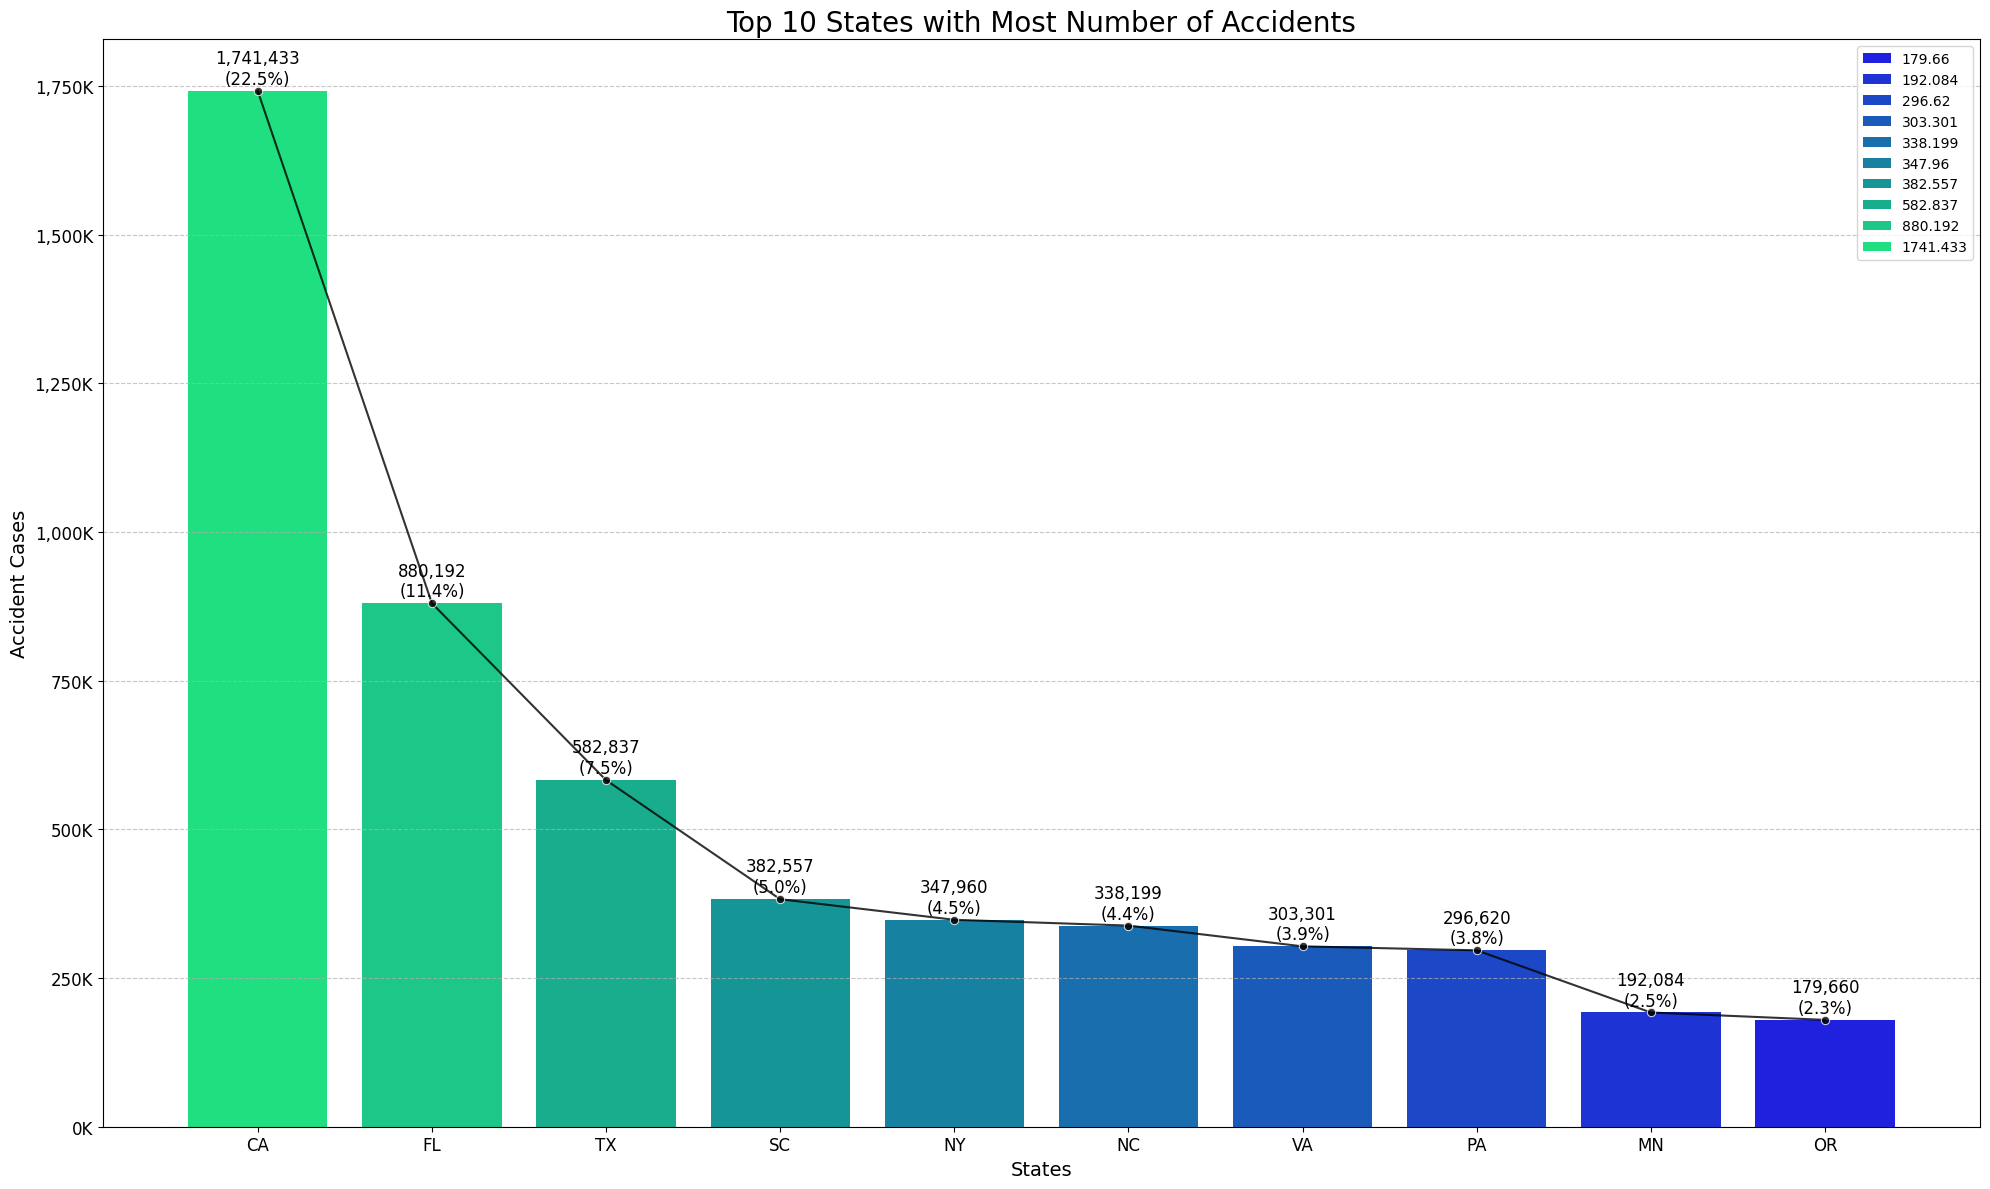

In [34]:
# Visualization for top 10 states
state_accidents = filtered_data.pivot_table(index='State', values='ID', aggfunc='count').rename(columns={'ID': 'Number_of_Accidents'})
state_accidents = state_accidents.sort_values(by='Number_of_Accidents', ascending=False).reset_index()

# To display the top 10 states with most number of accidents, we get head of 10 
top_states = state_accidents.head(10)

# Create the bar and line plot
plt.figure(figsize=(20, 12))
cmap = plt.cm.get_cmap('winter', 10)  # use winter colormap 
clrs = [matplotlib.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]

# Bar plot for the number of accidents
ax = sns.barplot(x=top_states['State'], y=top_states['Number_of_Accidents']/1000, hue=top_states['Number_of_Accidents']/1000, palette=clrs, dodge=False)

# Line plot overlayed on the bar plot
sns.lineplot(x=top_states['State'], y=top_states['Number_of_Accidents']/1000, data=top_states, marker='o', color='black', alpha=0.8, ax=ax)

# Annotate bar plot with accident counts and percentages
total_accidents = state_accidents['Number_of_Accidents'].sum()
for i, value in enumerate(top_states['Number_of_Accidents']):
    percentage = 100 * value / total_accidents
    ax.text(
        i, (value/1000) + 5,  # Adjust position above the bar
        f'{value:,}\n({percentage:.1f}%)',  # Add accident count and percentage
        ha='center', va='bottom', fontsize=12 )


plt.title('Top 10 States with Most Number of Accidents', fontsize=20)
ax.set_xlabel('States', fontsize=14)
ax.set_ylabel('Accident Cases', fontsize=14)

# Adjust axis ticks and grid
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Format the y-axis labels with K
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, _: f'{int(x):,}K'))

plt.tight_layout()
plt.show()


/var/folders/l_/p30b7fvj58l9wzkln6ww9qg00000gn/T/ipykernel_41950/2404310444.py:9: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



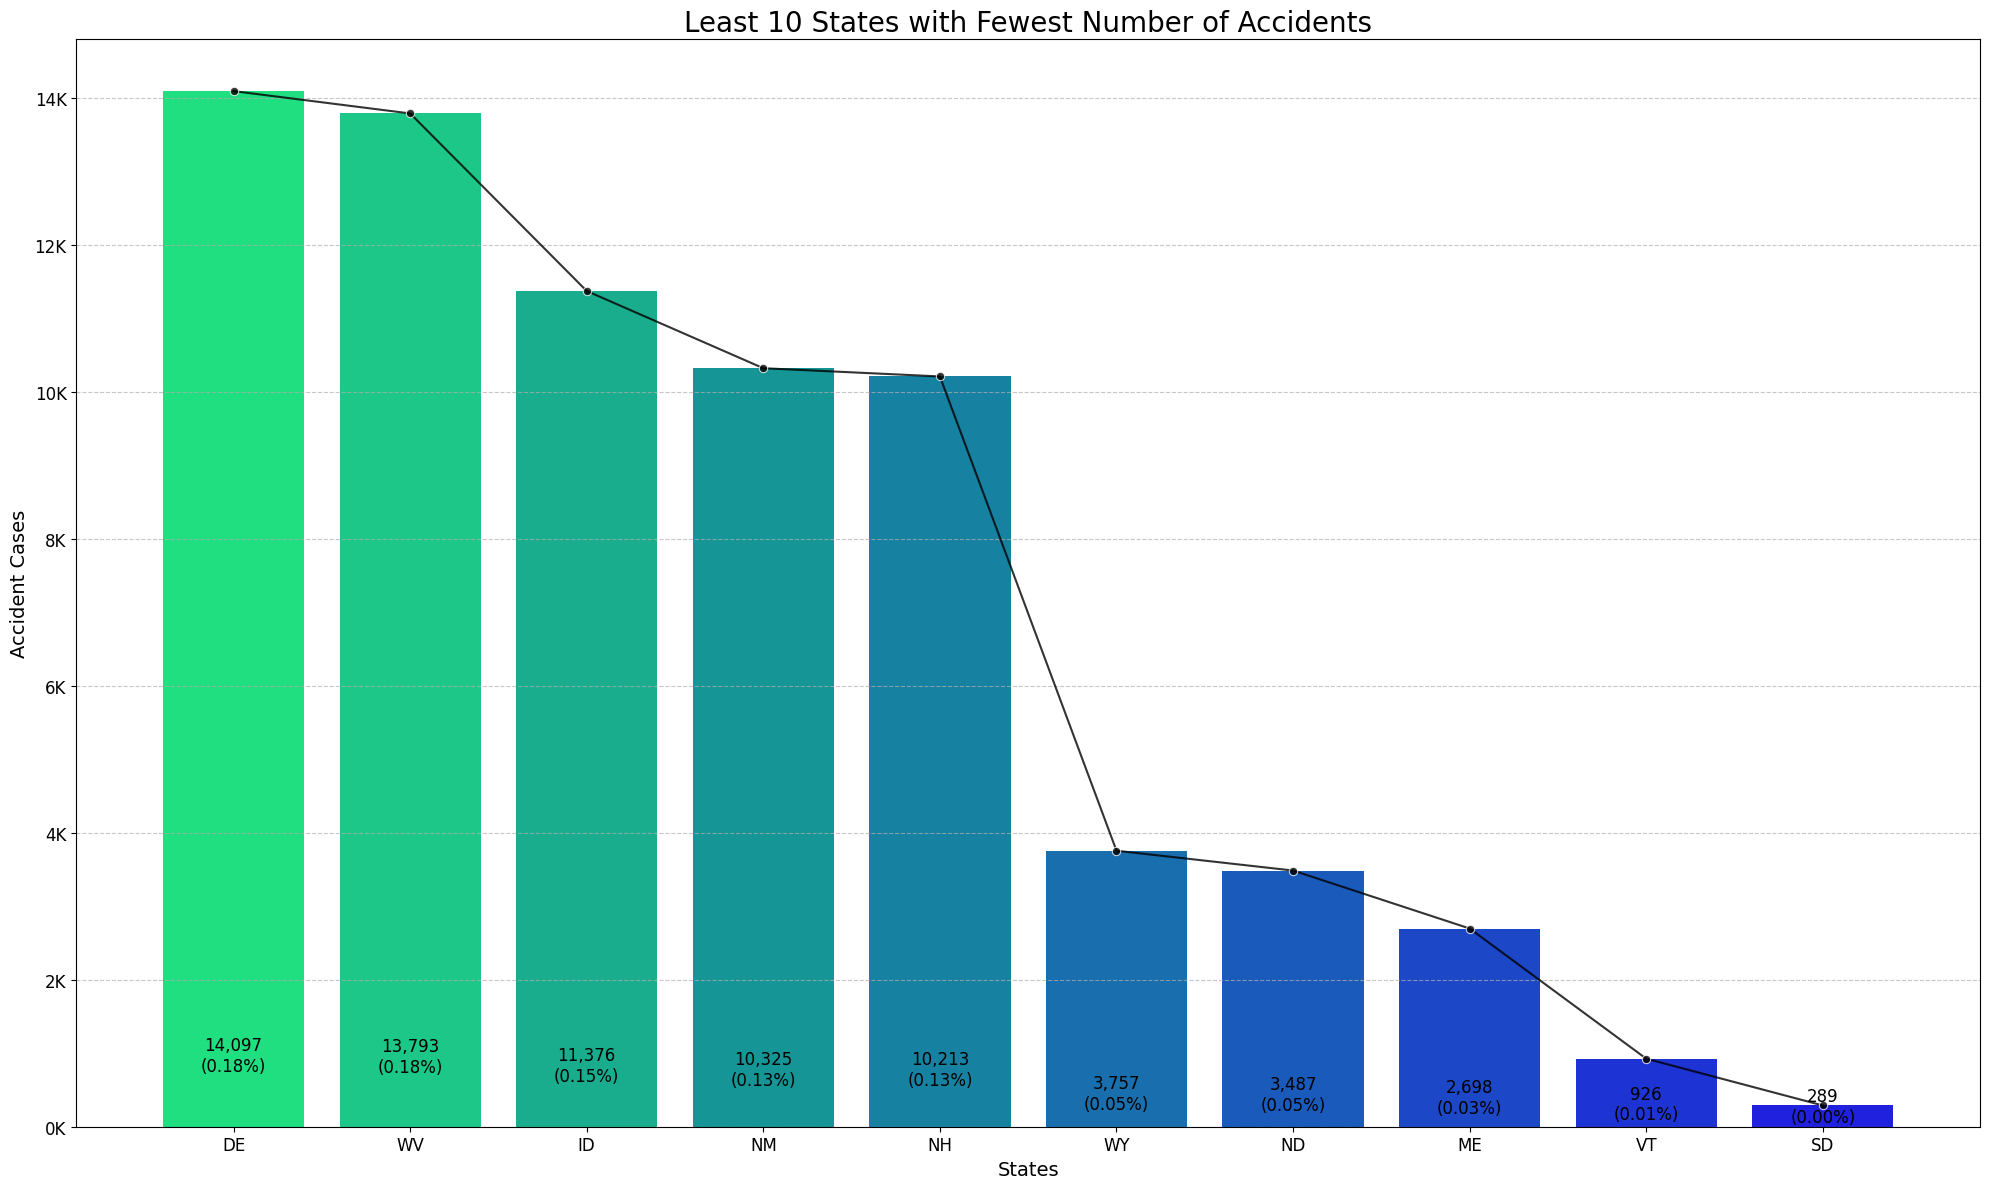

In [35]:
# Visualization for least 10 states
state_accidents = filtered_data.pivot_table(index='State', values='ID', aggfunc='count').rename(columns={'ID': 'Number_of_Accidents'})
state_accidents = state_accidents.sort_values(by='Number_of_Accidents', ascending=False).reset_index()
# To display the least 10 states with the fewest accidents
least_states = state_accidents.tail(10)

# Create the bar and line plot
plt.figure(figsize=(20, 12))
cmap = plt.cm.get_cmap('winter', 10)  # Use winter colormap
clrs = [matplotlib.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]

# Bar plot for the number of accidents
ax = sns.barplot(x=least_states['State'], y=least_states['Number_of_Accidents']/1000, hue=least_states['Number_of_Accidents']/1000, palette=clrs, dodge=False)

# Line plot overlayed on the bar plot
sns.lineplot(x=least_states['State'], y=least_states['Number_of_Accidents']/1000, data=least_states, marker='o', color='black', alpha=0.8, ax=ax)

# Annotate bar plot with accident counts and percentages
total_accidents = state_accidents['Number_of_Accidents'].sum()
for i, value in enumerate(least_states['Number_of_Accidents']):
    percentage = 100 * value / total_accidents
    ax.text(
        i, (value/1000) * 0.05 , # Locate the counts and percentages 
        f'{value:,}\n({percentage:.2f}%)',  # Add accident count and percentage
        ha='center', va='bottom', fontsize=12, color= 'black'
    )

# Title and axis labels
plt.title('Least 10 States with Fewest Number of Accidents', fontsize=20)
ax.set_xlabel('States', fontsize=14)
ax.set_ylabel('Accident Cases', fontsize=14)

# Adjust axis ticks and grid
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Format the y-axis labels with K
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, _: f'{int(x):,}K'))
ax.legend_.remove()
# Adjust layout
plt.tight_layout()
plt.show()


## Boxplots to visualize how severity varies under different weather conditions

##### This boxplot visualizes the variation in accident severity across different frequent weather conditions. Each box represents the distribution of severity scores for a specific weather condition, showing the median, quartiles, and potential outliers. For instance, conditions like Fog or Snow might exhibit higher severity due to reduced visibility or slippery roads. 

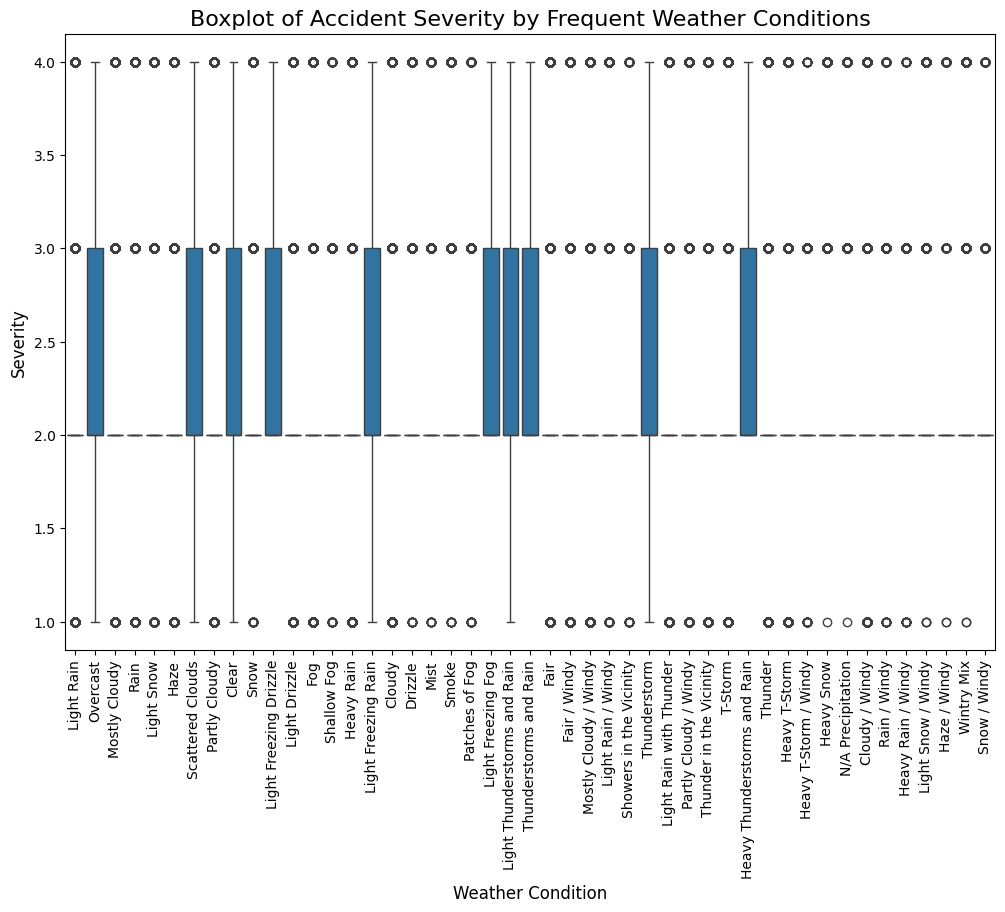

In [36]:
columns_to_use = ['Severity', 'Weather_Condition']
filtered_data = df[columns_to_use].dropna()
weather_counts = filtered_data['Weather_Condition'].value_counts()
threshold = 1000
frequent_weather_conditions = weather_counts[weather_counts > threshold].index
filtered_data = filtered_data[filtered_data['Weather_Condition'].isin(frequent_weather_conditions)]

plt.figure(figsize=(12, 8))
sns.boxplot(x='Weather_Condition', y='Severity', data=filtered_data)
plt.title('Boxplot of Accident Severity by Frequent Weather Conditions', fontsize=16)
plt.xlabel('Weather Condition', fontsize=12)
plt.ylabel('Severity', fontsize=12)
plt.xticks(rotation=90)
plt.show()


##### This bar chart shows the top 10 weather conditions associated with the most accident cases. The x axis represents the number of accidents, and each bar is annotated with the percentage contribution of that weather condition to the total accidents. 

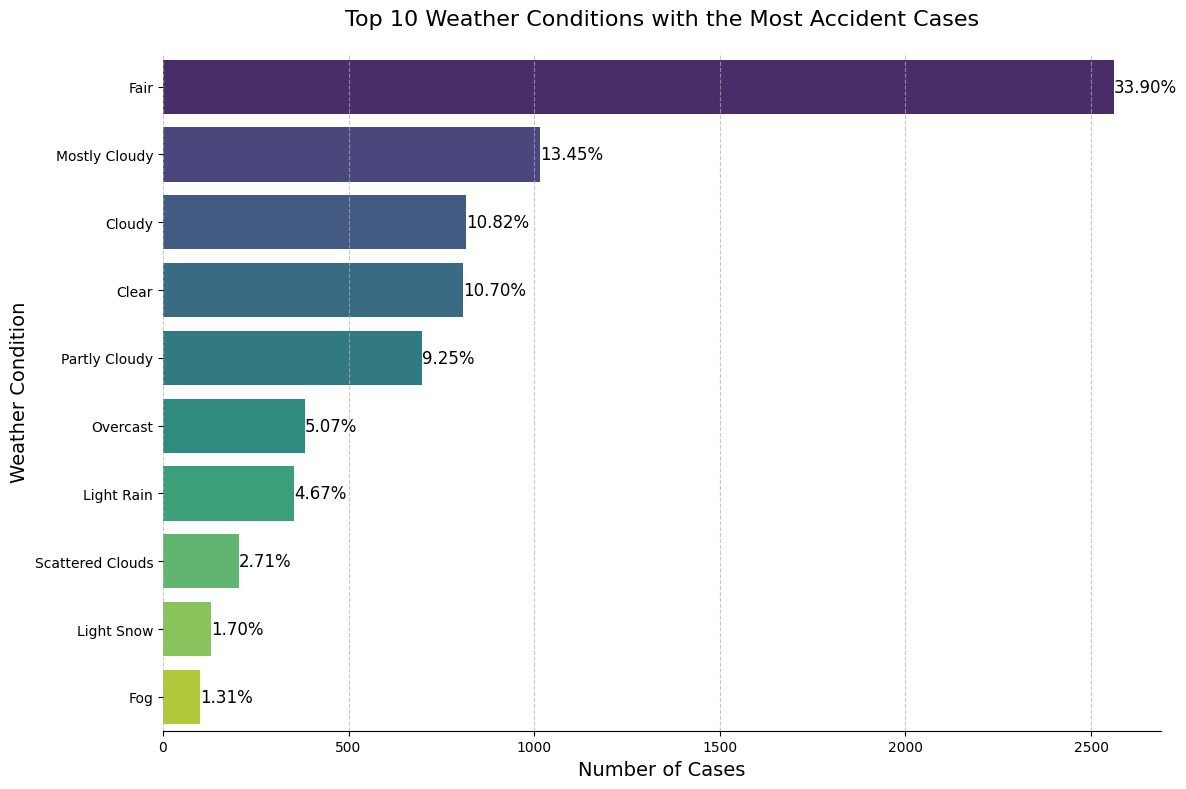

In [37]:
weather_condition_df = pd.DataFrame({'Weather_Condition': frequent_weather_conditions, 'Cases': weather_counts[frequent_weather_conditions].values})
weather_condition_df = weather_condition_df.head(10)  # We select the top 10 frequent weather conditions
total_cases = weather_counts.sum()
weather_condition_df['Percentage'] = (weather_condition_df['Cases'] / total_cases) * 100

# Convert Cases to K unit 
weather_condition_df['Cases_K'] = weather_condition_df['Cases'] / 1000

# Plot bar chart
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Cases_K', 
    y='Weather_Condition', 
    data=weather_condition_df,
    hue='Weather_Condition',
    dodge=False,
    palette='viridis',
)

# Bar chart with percentages
for index, row in weather_condition_df.iterrows():
    plt.text(
        row['Cases_K'], 
        index, 
        f"{row['Percentage']:.2f}%", 
        color='black', 
        va='center', 
        fontsize=12
    )

# Add titles and labels
plt.title('Top 10 Weather Conditions with the Most Accident Cases', fontsize=16, pad=20)
plt.xlabel('Number of Cases', fontsize=14)
plt.ylabel('Weather Condition', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)

for spine in ['top', 'right', 'left']:
    plt.gca().spines[spine].set_visible(False)

plt.tight_layout()
plt.show()


## Seasonal decomposition charts to highlight recurring patterns

##### This seasonal decomposition chart breaks down the monthly accident trends into four components: the original data, which shows the overall trend; the trend component, showing long-term changes in accident frequencies; the seasonal component, which reveals recurring patterns or cycles and the residual component, capturing irregularities or noise that cannot be explained by the trend or seasonality. 

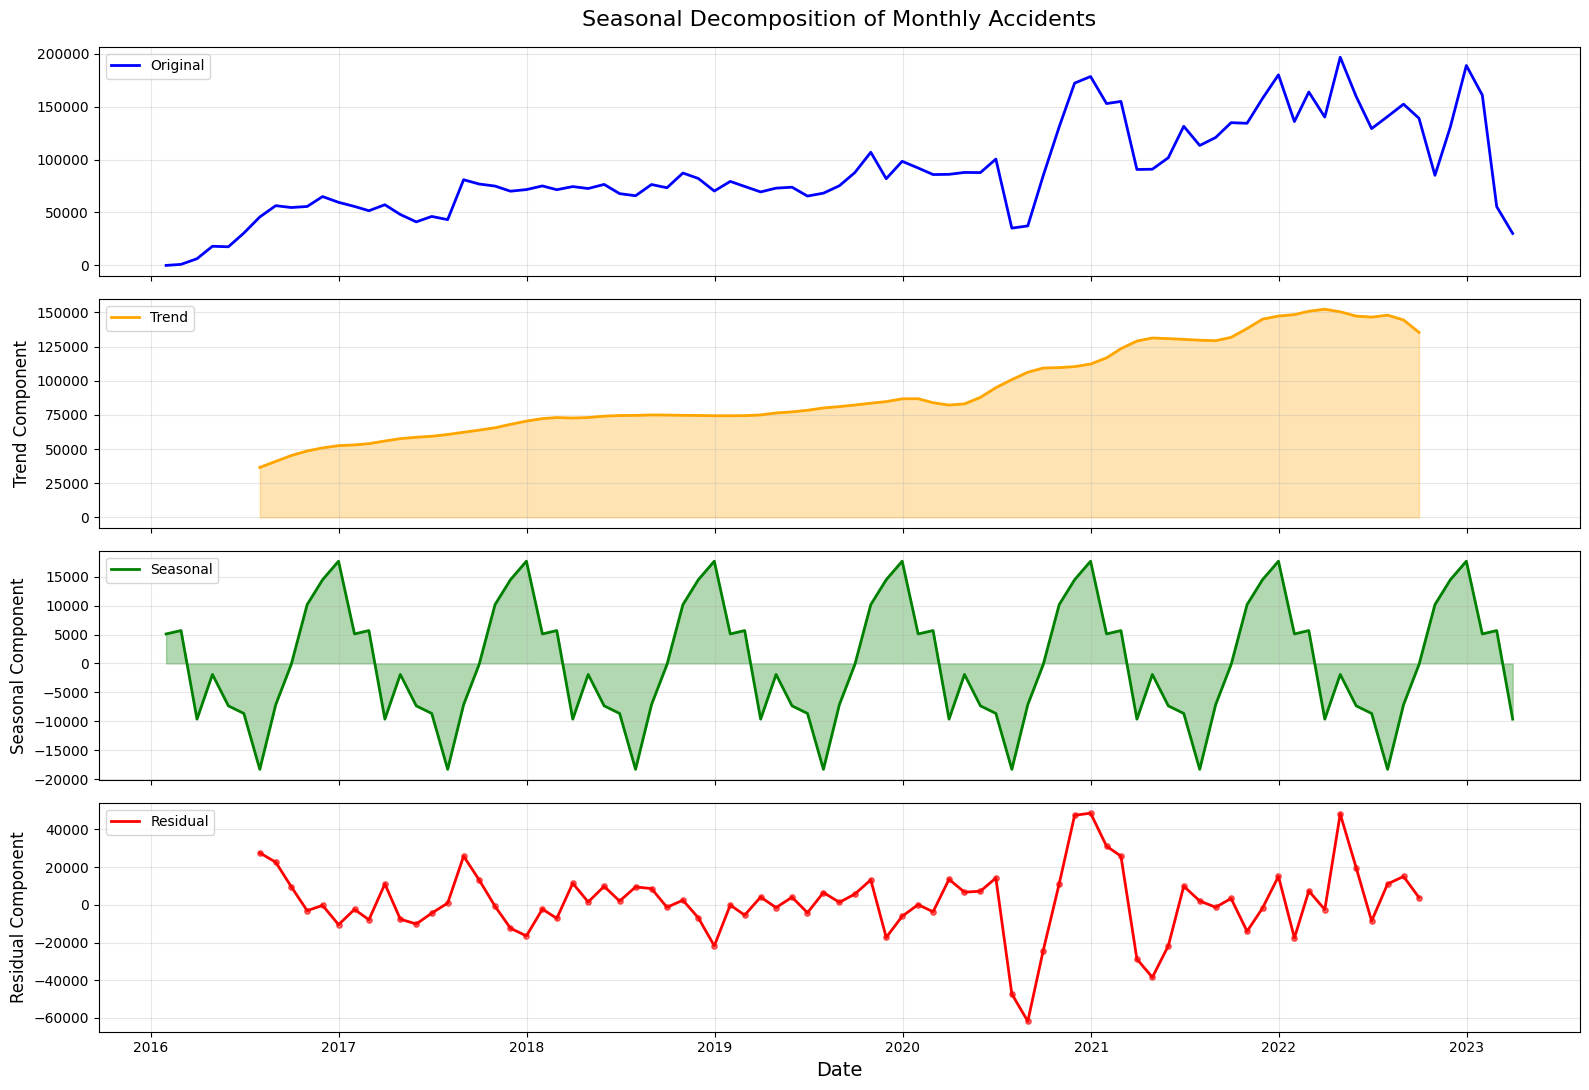

In [42]:
# perform Seasonal Decomposition
df['Start_Time'] = pd.to_datetime(df['Start_Time'])
monthly_accidents = df.resample('M', on='Start_Time').size()
decomposition = seasonal_decompose(monthly_accidents, model='additive', period=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, axes = plt.subplots(4, 1, figsize=(16, 11), sharex=True)

# Original data
axes[0].plot(monthly_accidents, label='Original', color='blue', linewidth=2)
axes[0].set_title('Seasonal Decomposition of Monthly Accidents', fontsize=16, pad=15)
axes[0].legend(loc='upper left', fontsize=10)
axes[0].grid(alpha=0.3)

# Trend
axes[1].plot(trend, label='Trend', color='orange', linewidth=2)
axes[1].fill_between(trend.index, trend, color='orange', alpha=0.3)
axes[1].legend(loc='upper left', fontsize=10)
axes[1].set_ylabel('Trend Component', fontsize=12)
axes[1].grid(alpha=0.3)

# Seasonal
axes[2].plot(seasonal, label='Seasonal', color='green', linewidth=2)
axes[2].fill_between(seasonal.index, seasonal, color='green', alpha=0.3)
axes[2].legend(loc='upper left', fontsize=10)
axes[2].set_ylabel('Seasonal Component', fontsize=12)
axes[2].grid(alpha=0.3)

# Residual
axes[3].plot(residual, label='Residual', color='red', linewidth=2)
axes[3].scatter(residual.index, residual, color='red', alpha=0.6, s=15)  # Add scatter for residuals
axes[3].legend(loc='upper left', fontsize=10)
axes[3].set_ylabel('Residual Component', fontsize=12)
axes[3].grid(alpha=0.3)

# Common x-label
axes[3].set_xlabel('Date', fontsize=14)

# Improve spacing
plt.tight_layout()
plt.show()


## Geospatial heatmaps to identify accident hotspots across states and cities

##### This geospatial heatmap visualizes accident hotspots across the United States by mapping accident locations onto a hexagonal grid. The intensity of color in each hexagon reflects the concentration of accidents, with brighter areas shows higher accident densities. 

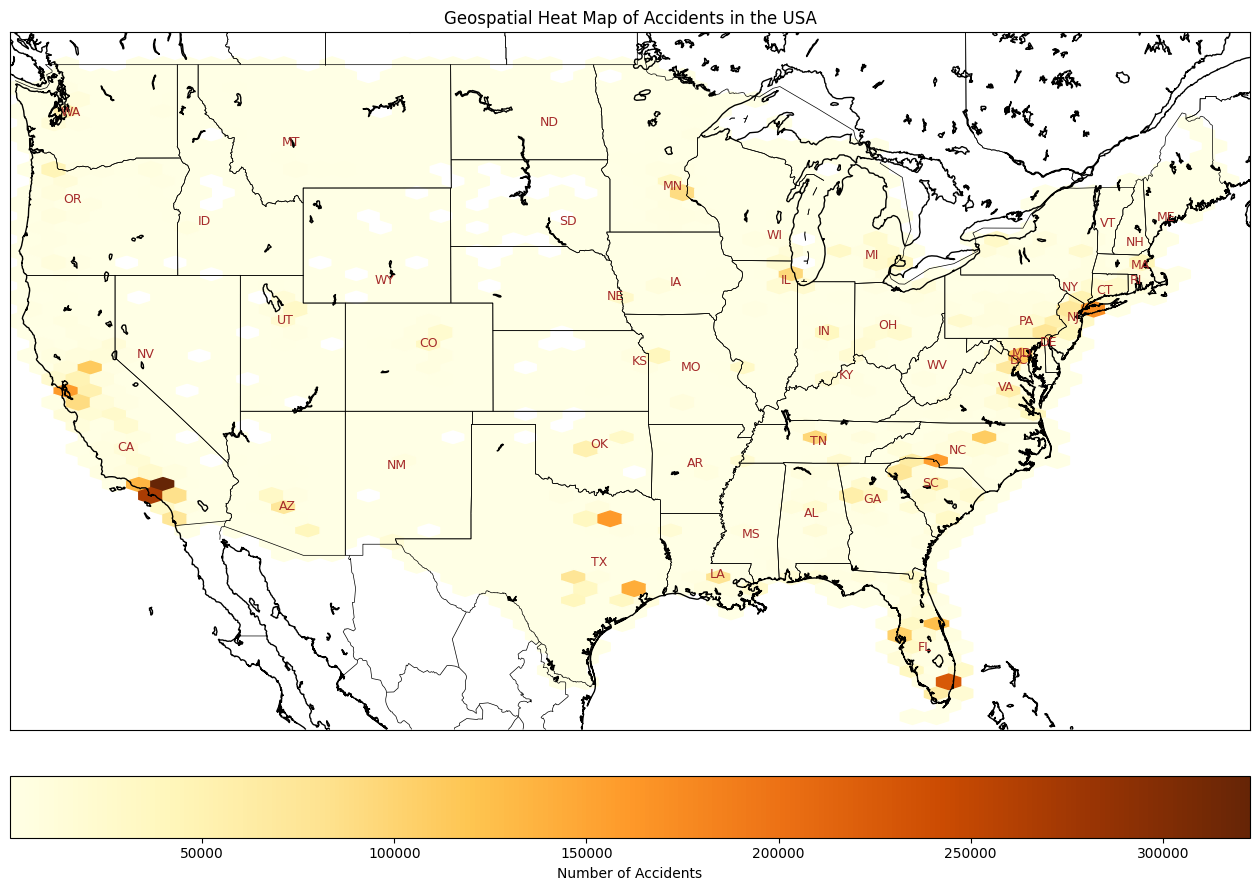

In [39]:
columns_to_use = ['Start_Lat', 'Start_Lng', 'State']
filtered_data = df[columns_to_use].dropna()

# Create a basemap
plt.figure(figsize=(16, 12))
m = Basemap(projection='merc', llcrnrlat=24, urcrnrlat=50, llcrnrlon=-125, urcrnrlon=-66, resolution='i')

# Draw coastlines, countries, and states
m.drawcoastlines()
m.drawcountries()
m.drawstates()

# Convert lat/lon to map projection coordinates
lons = filtered_data['Start_Lng'].values
lats = filtered_data['Start_Lat'].values
x, y = m(lons, lats)

# Create a heat map with normalization
hb = m.hexbin(x, y, gridsize=50, cmap='YlOrBr', mincnt=1, reduce_C_function=np.log10)

# Calculate centroids of states for annotation
state_centroids = filtered_data.groupby('State').agg({'Start_Lat': 'mean', 'Start_Lng': 'mean'}).reset_index()

for i, row in state_centroids.iterrows():
    lon, lat = row['Start_Lng'], row['Start_Lat']
    state = row['State']
    x, y = m(lon, lat)
    plt.text(x, y, state, fontsize=9, ha='center', va='center', color='brown')

plt.title('Geospatial Heat Map of Accidents in the USA')

cb = plt.colorbar(hb, orientation='horizontal', pad=0.05)
cb.set_label('Number of Accidents')

plt.show()


## Bubble maps highlighting the 50 most dangerous cities

##### This bubble map shows the 50 most dangerous cities based on accident frequency, with each bubble's size and color representing the number of accidents in that city. Larger and darker red bubbles indicate cities with higher accident counts, while smaller, lighter bubbles represent lower accident frequencies. The map also labels the top 10 cities for better clarity. 

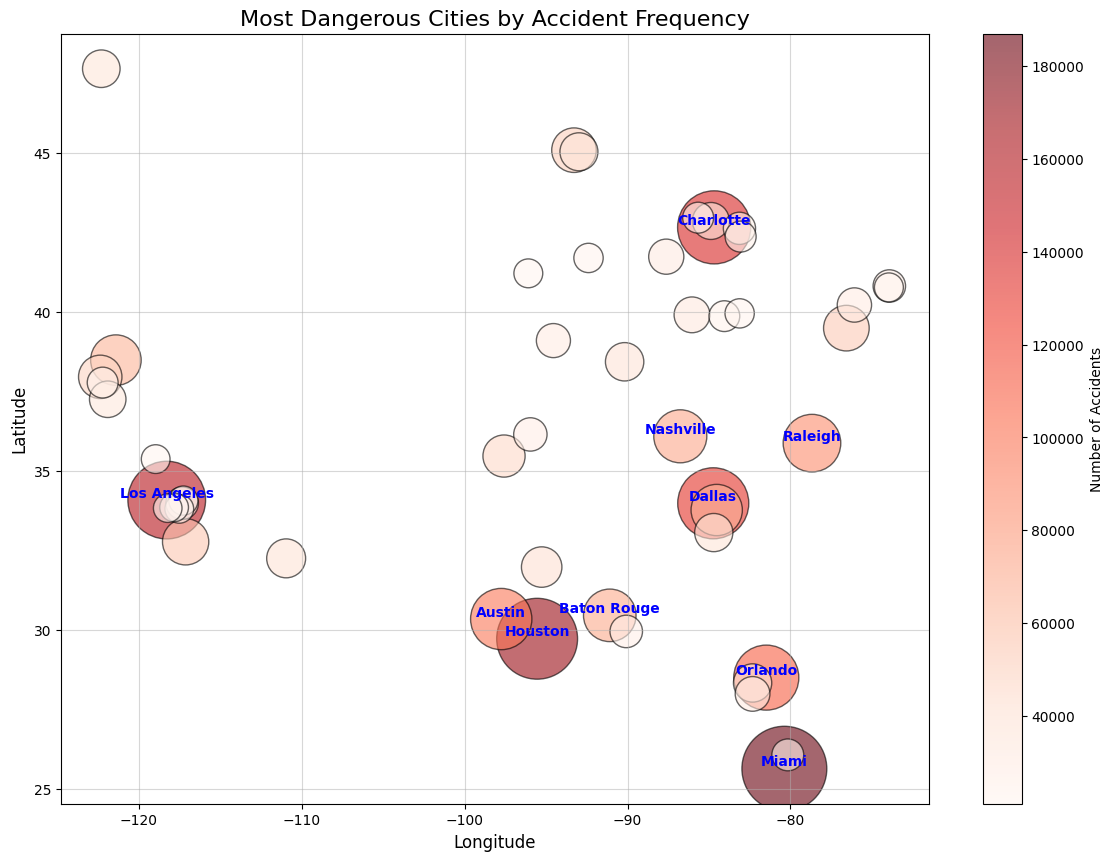

In [43]:
columns_to_use = ['City', 'Start_Lat', 'Start_Lng', 'ID']
filtered_data = df[columns_to_use].dropna()

# Group by city and count the number of accidents
city_accidents = filtered_data.groupby('City').agg(
    {'Start_Lat': 'first', 'Start_Lng': 'first', 'ID': 'count'}
).reset_index().rename(columns={'ID': 'Number_of_Accidents'})

# Sort cities by the number of accidents in descending order
city_accidents = city_accidents.sort_values(by='Number_of_Accidents', ascending=False).head(50)  # Top 50 cities

# Create the bubble plot
plt.figure(figsize=(14, 10))
scatter = plt.scatter(
    city_accidents['Start_Lng'], 
    city_accidents['Start_Lat'], 
    s=city_accidents['Number_of_Accidents'] / 50,  # Fix bubble size
    alpha=0.6, 
    c=city_accidents['Number_of_Accidents'], 
    cmap='Reds', 
    edgecolor='k'
)

plt.colorbar(scatter, label='Number of Accidents')

plt.title('Most Dangerous Cities by Accident Frequency', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

# Top 10 cities for clarity
for i, row in city_accidents.head(10).iterrows():
    plt.text(
        x=row['Start_Lng'], 
        y=row['Start_Lat'], 
        s=row['City'], 
        fontsize=10, 
        ha='center', 
        va='bottom', 
        color='blue', 
        fontweight='bold'
    )

plt.grid(alpha=0.5)
plt.show()

## Interactive Dashboard

##### This interactive dashboard provides an analysis of US traffic accidents through four dynamic tabs. The Overview tab visualizes monthly accident trends for a selected year using a slider. The By State tab allows users to explore specifi state accident distributions by month with a dropdown menu. The By Time tab features a heatmap showing the hourly distribution of accidents across days of the week for a chosen year. The Severity Analysis tab presents a boxplot showing the relationship between weather conditions and accident severity. 

In [41]:
# Load the dataset
df = pd.read_csv('US_Accidents_March23.csv')

# Data preprocessing (repeating the necessary steps)
df['Start_Time'] = df['Start_Time'].str.split('.').str[0]
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df['Year'] = df['Start_Time'].dt.year
df['Month'] = df['Start_Time'].dt.month
df['Day'] = df['Start_Time'].dt.day
df['Hour'] = df['Start_Time'].dt.hour
df['Day_of_Week'] = df['Start_Time'].dt.dayofweek
day_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df['Day_of_Week'] = df['Day_of_Week'].map(day_map)

# Create the Dash app
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

app.layout = html.Div([
    html.H1('US Traffic Accidents Dashboard'),
    dcc.Tabs([
        dcc.Tab(label='Overview', children=[
            html.Div([
                dcc.Graph(id='accidents-over-time'),
                dcc.Slider(
                    id='year-slider',
                    min=df['Year'].min(),
                    max=df['Year'].max(),
                    value=df['Year'].min(),
                    marks={str(year): str(year) for year in df['Year'].unique()},
                    step=None
                )
            ])
        ]),
        dcc.Tab(label='By State', children=[
            html.Div([
                dcc.Dropdown(
                    id='state-dropdown',
                    options=[{'label': state, 'value': state} for state in df['State'].unique()],
                    value='CA'
                ),
                dcc.Graph(id='accidents-by-state')
            ])
        ]),
        dcc.Tab(label='By Time', children=[
            html.Div([
                dcc.Graph(id='heatmap'),
            ])
        ]),
        dcc.Tab(label='Severity Analysis', children=[
            html.Div([
                dcc.Graph(id='severity-boxplot'),
            ])
        ])
    ])
])

@app.callback(
    Output('accidents-over-time', 'figure'),
    [Input('year-slider', 'value')]
)
def update_accidents_over_time(selected_year):
    filtered_df = df[df['Year'] == selected_year]
    accidents_per_month = filtered_df.groupby('Month').size()
    fig = px.line(accidents_per_month, labels={'value': 'Number of Accidents', 'index': 'Month'})
    fig.update_layout(title=f'Accidents in {selected_year}', xaxis_title='Month', yaxis_title='Number of Accidents')
    return fig

@app.callback(
    Output('accidents-by-state', 'figure'),
    [Input('state-dropdown', 'value')]
)
def update_accidents_by_state(selected_state):
    filtered_df = df[df['State'] == selected_state]
    accidents_per_month = filtered_df.groupby('Month').size()
    fig = px.bar(accidents_per_month, labels={'value': 'Number of Accidents', 'index': 'Month'})
    fig.update_layout(title=f'Accidents in {selected_state}', xaxis_title='Month', yaxis_title='Number of Accidents')
    return fig

@app.callback(
    Output('heatmap', 'figure'),
    [Input('year-slider', 'value')]
)
def update_heatmap(selected_year):
    filtered_df = df[df['Year'] == selected_year]
    heatmap_data = filtered_df.pivot_table(index='Day_of_Week', columns='Hour', aggfunc='size', fill_value=0)
    heatmap_data = heatmap_data.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    fig = px.imshow(heatmap_data, labels=dict(x="Hour", y="Day of the Week", color="Number of Accidents"))
    fig.update_layout(title=f'Accident Frequency by Hour and Day of the Week in {selected_year}')
    return fig

@app.callback(
    Output('severity-boxplot', 'figure'),
    [Input('year-slider', 'value')]
)
def update_severity_boxplot(selected_year):
    filtered_df = df[df['Year'] == selected_year]
    fig = px.box(filtered_df, x='Weather_Condition', y='Severity', title=f'Accident Severity by Weather Condition in {selected_year}')
    fig.update_layout(xaxis_title='Weather Condition', yaxis_title='Severity')
    return fig

if __name__ == '__main__':
    app.run_server(debug=True)
